# 1C Company ソフトウェアのデベロッパー
1C Companyは、独立したソフトウェア開発者、ディストリビューター、およびパブリッシャーであり、本社はロシアのモスクワにあります。コンピュータソフトウェア、関連サービス、ビデオゲームを開発、製造、ライセンス、サポート、販売しています。

前提
* 各ショップで販売された製品の総量を予測
* ショップや商品のリストは毎月若干異なる
* test.csvのshop x itemの2015年11月の売上を予測
* 指標はRMSE


確認したきこと
* CVなしの日が存在するか？(店舗ごとにみたほうがよい？)
* 季節性(ロシアだけに冬場CVが少ないとか)
* test.csvの組み合わせについて、過去実績があるか？

など

他
* なお、ショップや商品のリストは毎月若干異なります。このような状況を処理できる堅牢なモデルを作成することは、課題の一部です。
→　2015/11に特化しないモデルという解釈？


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
# ライブラリのロード
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
import io

sales_train.csv-トレーニングセット。2013年1月から2015年10月までの毎日の履歴データ。  
test.csv-テストセット。これらのショップと製品の2015年11月の売上を予測する必要があります。  
sample_submission.csv-正しい形式のサンプル送信ファイル。  
items.csv-アイテム/製品に関する補足情報。  
item_categories.csv-   アイテムのカテゴリに関する補足情報。  
shop.csv-ショップに関する補足情報。  

In [3]:
# ローカルのファイルをロード
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sample_submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
shop = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
item = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')


In [4]:
sample_submission.count()

ID                214200
item_cnt_month    214200
dtype: int64

In [5]:
print(sample_submission)

            ID  item_cnt_month
0            0             0.5
1            1             0.5
2            2             0.5
3            3             0.5
4            4             0.5
...        ...             ...
214195  214195             0.5
214196  214196             0.5
214197  214197             0.5
214198  214198             0.5
214199  214199             0.5

[214200 rows x 2 columns]


In [6]:
test.count()

ID         214200
shop_id    214200
item_id    214200
dtype: int64

In [7]:
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
shop.count()

shop_name    60
shop_id      60
dtype: int64

In [9]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item.count()

item_name           22170
item_id             22170
item_category_id    22170
dtype: int64

In [11]:
print(60*22170)

1330200


テストとアイテム＊ショップが一致しないのでテストは対象アイテムと店舗が絞られている。

In [12]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [14]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


item_cnt_dayにマイナス値が存在？返品か？  
値は月単位に集計しclipするため除外や0埋めは行えない。

In [15]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [16]:
sales_train.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

# sales_trainのitem_cnt_dayに外れ値が無いか確認してみる

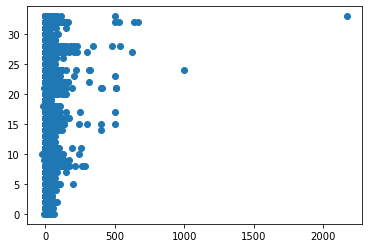

In [17]:
# item_cnt_day 
x = sales_train['item_cnt_day']
y = sales_train['date_block_num']
 
# 散布図を描画
plt.scatter(x, y)

何か売上個数がぶっ飛んだアイテムが存在している。

In [18]:
day_cnt_over = sales_train[sales_train['item_cnt_day'] > 1000]
print(day_cnt_over)

               date  date_block_num  shop_id  item_id  item_price  \
2909818  28.10.2015              33       12    11373    0.908714   

         item_cnt_day  
2909818        2169.0  


In [19]:
day_cnt_over_item = pd.merge(day_cnt_over, item, on='item_id', how='left')
print(day_cnt_over_item)


         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  28.10.2015              33       12    11373    0.908714        2169.0   

                              item_name  item_category_id  
0  Доставка до пункта выдачи (Boxberry)                 9  


Доставка до пункта выдачи(Boxberry)  

問題点への配送(Boxberry) : 故障？などの配送？ 

In [20]:
item_check = sales_train[sales_train['item_id'] == 11373]
print(item_check)

               date  date_block_num  shop_id  item_id  item_price  \
58323    08.01.2013               0       12    11373     1000.00   
58324    31.01.2013               0       12    11373       97.80   
176790   01.02.2013               1       12    11373      229.00   
176791   04.02.2013               1       12    11373      130.00   
302468   29.03.2013               2       12    11373      139.50   
...             ...             ...      ...      ...         ...   
2909829  07.10.2015              33       12    11373      855.00   
2909830  06.10.2015              33       12    11373      208.80   
2909831  05.10.2015              33       12    11373      140.75   
2909832  02.10.2015              33       12    11373      648.50   
2909856  01.10.2015              33       12    11373      361.25   

         item_cnt_day  
58323             1.0  
58324             5.0  
176790            1.0  
176791            1.0  
302468            2.0  
...               ...  
290

priceにバラつきがある。


In [21]:
price_mean = item_check.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['mean']})
print(price_mean)

                               item_cnt_day
                                       mean
date_block_num shop_id item_id             
0              12      11373       3.000000
1              12      11373       1.000000
2              12      11373       3.500000
3              12      11373       1.800000
4              12      11373       1.166667
5              12      11373       2.800000
6              12      11373       1.125000
7              12      11373       4.875000
8              12      11373       2.062500
9              12      11373       4.636364
10             12      11373      31.083333
11             12      11373       7.700000
12             12      11373       3.833333
13             12      11373      12.200000
14             12      11373      14.500000
15             12      11373       4.066667
16             12      11373       9.800000
17             12      11373       4.166667
18             12      11373       2.285714
19             12      11373    

* shop依存のアイテム。。。 
* 33か月目の1日当たりの平均が異常


In [22]:
price_mean2=item_check[(item_check['item_cnt_day'] < 1000) & (item_check['date_block_num'] == 33) ].groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['mean']})
print(price_mean2)

                               item_cnt_day
                                       mean
date_block_num shop_id item_id             
33             12      11373       4.666667


* 1日除くと平均値がかなり下がる。
* 異常値っぽいので除外してみるか？

In [23]:
check = test[test['item_id'] == 11373]
check.head()

,ID,shop_id,item_id
1596,1596,5,11373
6696,6696,4,11373
11796,11796,6,11373
16896,16896,3,11373
21996,21996,2,11373


TESTには各店舗分データが存在している。。。

# sales_trainのitem_priceに外れ値が無いか確認してみる

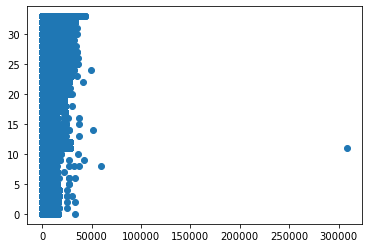

In [24]:
# item_price 
x = sales_train['item_price']
y = sales_train['date_block_num']
 
# 散布図を描画
plt.scatter(x, y)

何か激しく外れている商品が存在する。

In [25]:
over = sales_train[sales_train['item_price'] > 50000 ]
over_item = pd.merge(over, item, on='item_id', how='left')
print(over_item )

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  17.09.2013               8       12    11365     59200.0           1.0   
1  13.12.2013              11       12     6066    307980.0           1.0   
2  20.03.2014              14       25    13199     50999.0           1.0   

                                 item_name  item_category_id  
0                           Доставка (EMS)                 9  
1                     Radmin 3  - 522 лиц.                75  
2  Коллекционные шахматы (Властелин Колец)                69  


Radmin 3(VPNのソフト)  522日ライセンスらしい、
item_priceが50000以上のアイテムはCVが1件のため除外してよいと思われる。

# 周期性を確認してみる

In [26]:
df = pd.merge(sales_train.sort_values(by='date'), item.drop('item_name', axis=1), on='item_id', how='left')

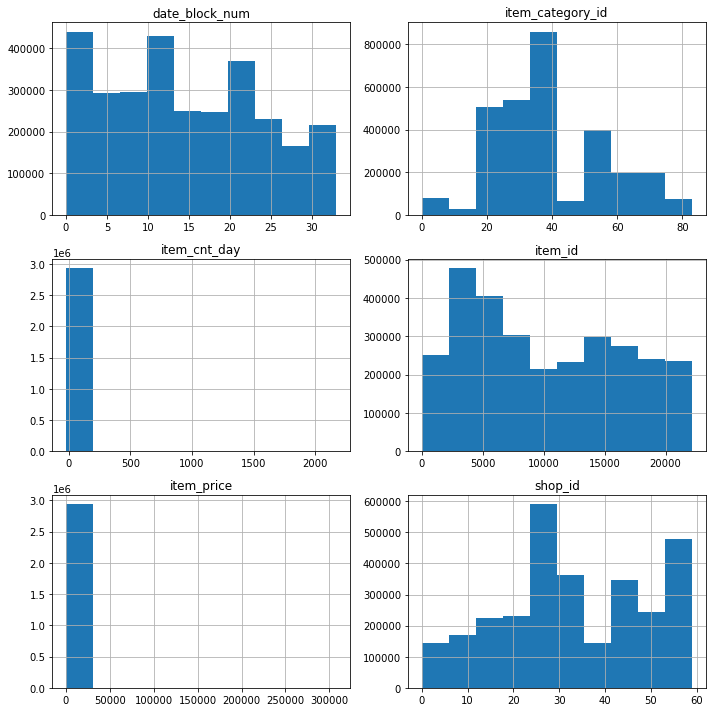

In [27]:
from pylab import rcParams

rcParams['figure.figsize'] = 10, 10
df.hist()
plt.tight_layout()
plt.show()

* 上記はレコード数単位であり、売上個数でないことに注意
* data_block_num : 月日が経つにつれ売れているアイテムの種類は減少している。
* item_category_id : カテゴリごとにバラつきがある
* item_id : 0 ~ 10000番台のアイテムの登場回数が多い
* shop_id : 店舗ごとに売り上げのバラつきがある

# 売れているアイテム

In [28]:
df_item = df[['item_id','item_cnt_day']].groupby(['item_id'])['item_cnt_day'].apply(np.sum)

In [29]:
df_item.sort_values(ascending=False).head()

item_id
20949    187642.0
2808      17245.0
3732      16642.0
17717     15830.0
5822      14515.0
Name: item_cnt_day, dtype: float64

In [30]:
print(item[item['item_id'] == 20949]) #1CパッケージTシャツ1Cインタレストホワイト
print(item[item['item_id'] == 2808])  #Diablo III (ゲーム)
print(item[item['item_id'] == 3732])  #プレイステーションストアウォレット
print(item[item['item_id'] == 17717]) #1C-Onlineの資金の受け入れ　課金？
print(item[item['item_id'] == 5822])  #プレイステーションストアウォレット

                                               item_name  item_id  \
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
20949                71  
                                   item_name  item_id  item_category_id
2808  Diablo III [PC, Jewel, русская версия]     2808                30
                                       item_name  item_id  item_category_id
3732  Grand Theft Auto V [PS3, русские субтитры]     3732                19
                                  item_name  item_id  item_category_id
17717  Прием денежных средств для 1С-Онлайн    17717                79
                                              item_name  item_id  \
5822  Playstation Store пополнение бумажника: Карта ...     5822   

      item_category_id  
5822                35  


Tシャツ  
ディアブロ  
GTA  
1C-Onlineの資金の受け入れ  課金？
ゲームばっかでワロタ


In [31]:
# shop の分析
print(shop)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

店名の先頭は地名らしく、ある程度の共通がみられる。  
Москва モスクワ  
分かち書きすれば、新たな特徴量になるか？  

以下重複しているっぽい  
10                       Жуковский ул. Чкалова 39м?       10  
11                       Жуковский ул. Чкалова 39м²       11  

0                     !Якутск Орджоникидзе, 56 фран        0  
57                          Якутск Орджоникидзе, 56       57  


1                     !Якутск ТЦ "Центральный" фран        1  
58                          Якутск ТЦ "Центральный"       58  




In [32]:
shop['city'] = shop['shop_name'].str.split(' ').map(lambda x: x[0])
shop['city'].value_counts(dropna=False)

Москва              13
РостовНаДону         3
Воронеж              3
Тюмень               3
Уфа                  2
Казань               2
Якутск               2
Жуковский            2
Красноярск           2
!Якутск              2
Новосибирск          2
Н.Новгород           2
СПб                  2
Самара               2
Интернет-магазин     1
Сергиев              1
Калуга               1
Коломна              1
Химки                1
Чехов                1
Мытищи               1
Томск                1
Цифровой             1
Омск                 1
Выездная             1
Вологда              1
Адыгея               1
Волжский             1
Сургут               1
Курск                1
Ярославль            1
Балашиха             1
Name: city, dtype: int64

重複あり
Якутск               2
!Якутск              2

# item 

In [33]:
#item
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


# item_category

In [34]:
#item_categories
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


-で分かち書きできそう

In [35]:
ic = item_categories['item_category_name'].str.split('-')

In [36]:
print(ic)

0                      [PC ,  Гарнитуры/Наушники]
1                             [Аксессуары ,  PS2]
2                             [Аксессуары ,  PS3]
3                             [Аксессуары ,  PS4]
4                             [Аксессуары ,  PSP]
5                          [Аксессуары ,  PSVita]
6                        [Аксессуары ,  XBOX 360]
7                        [Аксессуары ,  XBOX ONE]
8                                [Билеты (Цифра)]
9                               [Доставка товара]
10                       [Игровые консоли ,  PS2]
11                       [Игровые консоли ,  PS3]
12                       [Игровые консоли ,  PS4]
13                       [Игровые консоли ,  PSP]
14                    [Игровые консоли ,  PSVita]
15                  [Игровые консоли ,  XBOX 360]
16                  [Игровые консоли ,  XBOX ONE]
17                    [Игровые консоли ,  Прочие]
18                                  [Игры ,  PS2]
19                                  [Игры ,  PS3]


* 要素が2以上のものが存在している。うまくまとめられるか？

In [37]:
from sklearn.preprocessing import LabelEncoder

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['first'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['item_type'] = LabelEncoder().fit_transform(item_categories['first'])

item_categories['other'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['item_subtype'] = LabelEncoder().fit_transform(item_categories['other'])
item_categories = item_categories[['item_category_id','item_type', 'item_subtype']]

print(item_categories)

    item_category_id  item_type  item_subtype
0                  0          0            29
1                  1          1             9
2                  2          1            10
3                  3          1            11
4                  4          1            13
5                  5          1            14
6                  6          1            16
7                  7          1            17
8                  8          2            26
9                  9          3            33
10                10          4             9
11                11          4            10
12                12          4            11
13                13          4            13
14                14          4            14
15                15          4            16
16                16          4            17
17                17          4            50
18                18          5             9
19                19          5            10
20                20          5   

アイテムカテゴリについては上手く分割できそうである。

# まとめ
## sales_train
* item_cnt_dayに外れ値が存在する。1日2000以上のアイテムは除外しても問題なさそう。
* item_priceに外れ値が存在する。priceが50000以上のアイテムは除外しても問題なさそう。


## shop 
* 店舗に重複が存在する。
* shop_nameから、都市の特徴量が作れる。


## item_category
* item_categoryのitem_category_nameから、細かい粒度のアイテムの種別が作れる。